In [2]:
import polars as pl


This competition is going to focus on the commodity prediction challenge. The goal is to predict log returns

Loadingg the data

In [3]:
X = pl.read_csv('/kaggle/input/mitsui-commodity-prediction-challenge/train.csv')

y = pl.read_csv('/kaggle/input/mitsui-commodity-prediction-challenge/train_labels.csv')

Preprocessing and data analysis will include, PCA, Isomap. PCA will onyl be used for data analysis and variable selection. Dimensional reduction will be handled by isomap. data cleaning will just be median filling. More preprocessing will occur using log10, minmax scaler. More data analysis will occur by visually looking at the probability distributions and median, mean and IQR to determine how skewed the distribution is.  

LSTM with multi-head attention

After looking at the preliminary EDA of the x and y variables I have concluded that almost all of the y variables are skewed and fat tailed. Many of the input variables also exhibit bimodal distrbutions. I have concluded based on this that I should not use standard scaler and should isntead use minmax scaler and that I should take the log of data in order to "linearize" the data before engaging in dimensionality reduction to increase the accuracy of my deep learning neural networks

Generally skewed fat tailed distributions also indicate that the data follows long term dependence (past log returns would have major impact on current and future log returns). I thereofre have decided to account for this and increase the accuracy further by using a neural network acrhitecture that employs attention and lstm which function well with data that exhibits long term dependence compared to something like a vanilla RNN.  

I have decided that the best way to fill missing values is with the median for x and backfill for y

In [4]:
for col in X.columns:
    if X[col].dtype in [pl.Float64, pl.Int64]:
        median_value = X[col].median()
        X = X.with_columns([
            pl.col(col).fill_null(median_value).alias(col)
        ])

In [5]:
import polars as pl

for col in y.columns:
    if y[col].dtype in [pl.Float64, pl.Int64]:
        y = y.with_columns([
            pl.col(col).fill_null(strategy='backward').alias(col)
        ])




Data anlysis and feature selection

Selecting only most important features

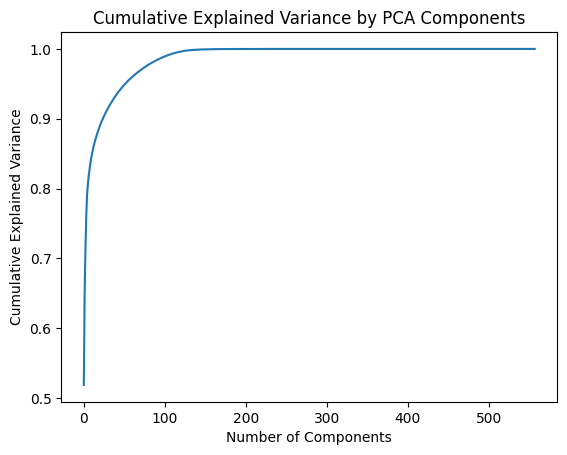

Top features in PC1: US_Stock_YINN_adj_volume    0.241657
US_Stock_URA_adj_volume     0.183576
US_Stock_YINN_adj_low       0.161456
US_Stock_YINN_adj_close     0.161210
US_Stock_YINN_adj_open      0.161194
US_Stock_YINN_adj_high      0.160882
US_Stock_VGLT_adj_volume    0.156276
US_Stock_SPTL_adj_volume    0.148277
US_Stock_VGIT_adj_volume    0.125003
US_Stock_RSP_adj_volume     0.123173
dtype: float64


In [6]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
df = X
features = [col for col in df.columns if col not in ['target', 'date', 'identifier']]  # adjust as needed

# Apply log10 transform (assumes all values are positive)
X_log = np.log10(df[features] + 1e-6)

# Optional: Remove any rows with NaN or -inf (if initial data had zeros)
X_log = pd.DataFrame(X_log, columns=features).replace([np.inf, -np.inf], np.nan).dropna()

# PCA for analysis/variable importance
pca = PCA()
X_pca = pca.fit_transform(X_log)
explained_var = pca.explained_variance_ratio_

# Plot cumulative explained variance
plt.plot(np.cumsum(explained_var))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance by PCA Components")
plt.show()

# Analyze feature importance (loadings) for PC1
loadings = pd.Series(pca.components_[0], index=features).abs().sort_values(ascending=False)
print("Top features in PC1:", loadings.head(10))


In [ ]:
#X = X[:, :10]
#y = y[:, :10]

preliminary Exploratory data analysis analysis. This looks at the way they are distributed, median, IQR and kurtoisis (explicit skew) 

In [71]:
important_features = [
    "US_Stock_YINN_adj_volume",
    "US_Stock_URA_adj_volume",
    "US_Stock_YINN_adj_low",
    "US_Stock_YINN_adj_close",
    "US_Stock_YINN_adj_open",
    "US_Stock_YINN_adj_high",
    "US_Stock_VGLT_adj_volume",
    "US_Stock_SPTL_adj_volume",
    "US_Stock_VGIT_adj_volume",
    "US_Stock_RSP_adj_volume"
]

# Assuming df is your original DataFrame
X = df[important_features]
print(X.head())

shape: (5, 10)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ US_Stock_ ┆ US_Stock_ ┆ US_Stock_ ┆ US_Stock_ ┆ … ┆ US_Stock_ ┆ US_Stock_ ┆ US_Stock_ ┆ US_Stock │
│ YINN_adj_ ┆ URA_adj_v ┆ YINN_adj_ ┆ YINN_adj_ ┆   ┆ VGLT_adj_ ┆ SPTL_adj_ ┆ VGIT_adj_ ┆ _RSP_adj │
│ volume    ┆ olume     ┆ low       ┆ close     ┆   ┆ volume    ┆ volume    ┆ volume    ┆ _volume  │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 51983.65  ┆ 608348.0  ┆ 664.5823  ┆ 676.2986  ┆ … ┆ 122068.0  ┆ 2.450873e ┆ 239750.0  ┆ 1.132667 │
│           ┆           ┆           ┆           ┆   ┆           ┆ 6         ┆           ┆ e6       │
│ 39273.0   ┆ 655209.0  ┆ 682.0378  ┆ 694.5039  ┆ … ┆ 34298.0   ┆ 295799.0  

Input feature distributions:


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


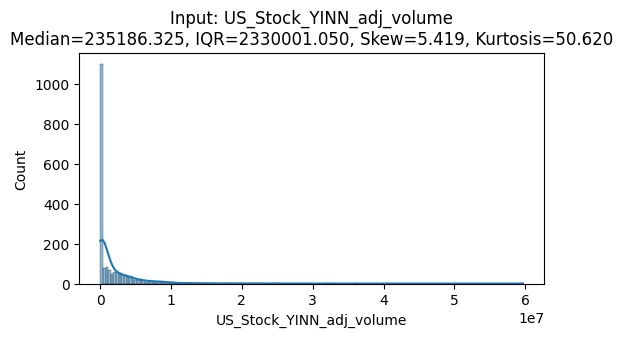

US_Stock_YINN_adj_volume: Median=235186.325, IQR=2330001.050, Skew=5.419, Kurtosis=50.620 Fat-tailed



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


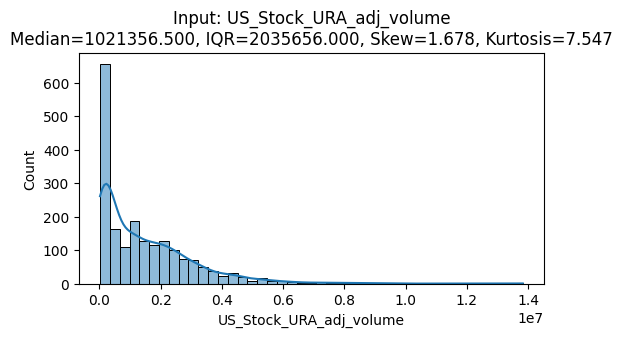

US_Stock_URA_adj_volume: Median=1021356.500, IQR=2035656.000, Skew=1.678, Kurtosis=7.547 Fat-tailed



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


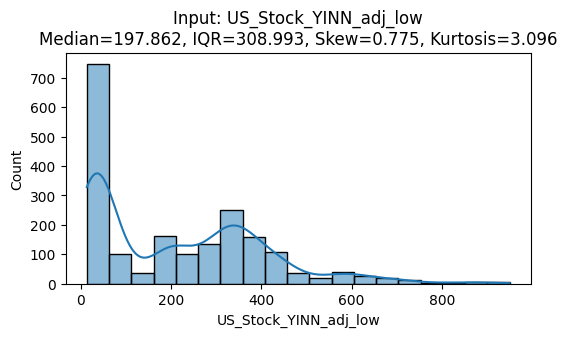

US_Stock_YINN_adj_low: Median=197.862, IQR=308.993, Skew=0.775, Kurtosis=3.096 Fat-tailed



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


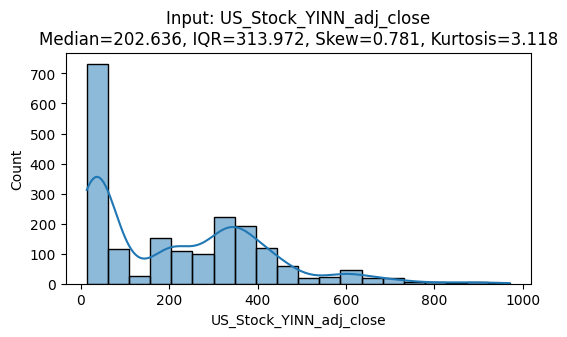

US_Stock_YINN_adj_close: Median=202.636, IQR=313.972, Skew=0.781, Kurtosis=3.118 Fat-tailed



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


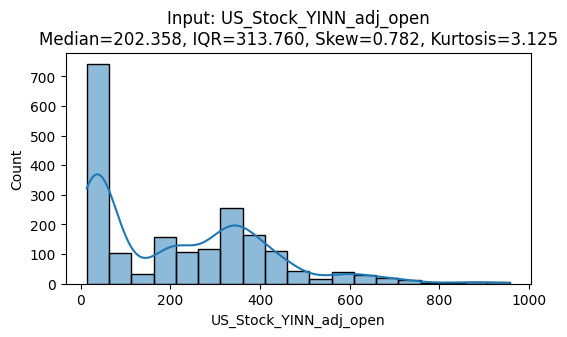

US_Stock_YINN_adj_open: Median=202.358, IQR=313.760, Skew=0.782, Kurtosis=3.125 Fat-tailed



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


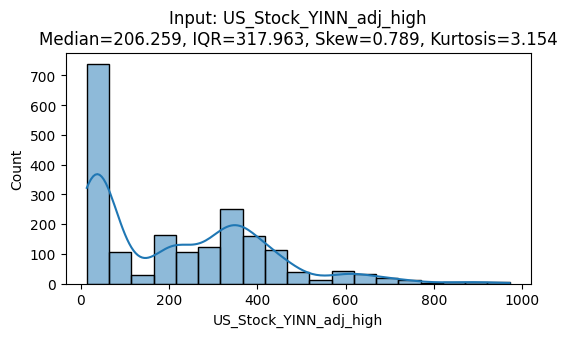

US_Stock_YINN_adj_high: Median=206.259, IQR=317.963, Skew=0.789, Kurtosis=3.154 Fat-tailed



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


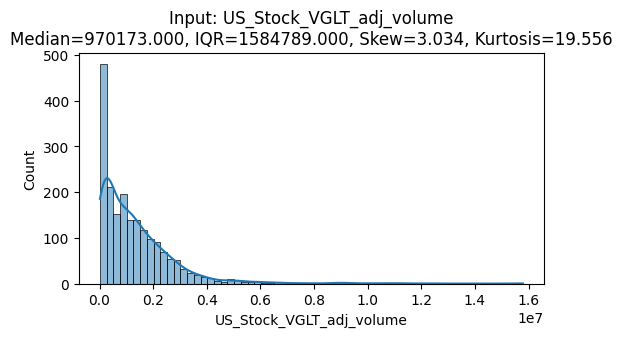

US_Stock_VGLT_adj_volume: Median=970173.000, IQR=1584789.000, Skew=3.034, Kurtosis=19.556 Fat-tailed



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


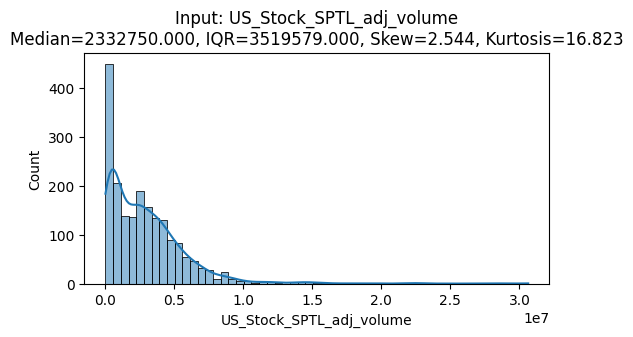

US_Stock_SPTL_adj_volume: Median=2332750.000, IQR=3519579.000, Skew=2.544, Kurtosis=16.823 Fat-tailed



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


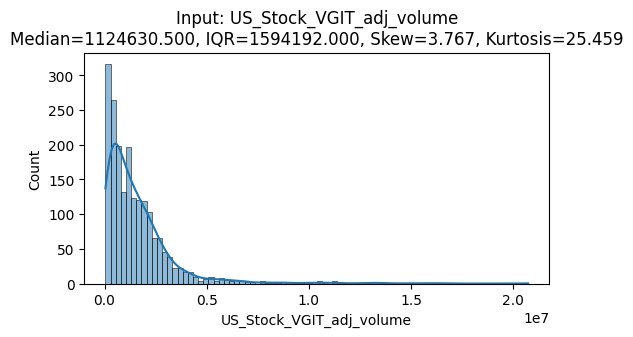

US_Stock_VGIT_adj_volume: Median=1124630.500, IQR=1594192.000, Skew=3.767, Kurtosis=25.459 Fat-tailed



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


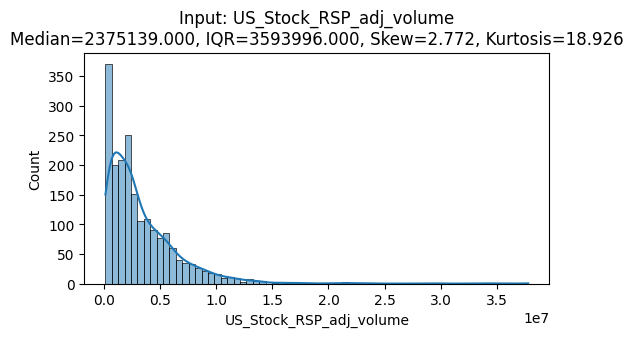

US_Stock_RSP_adj_volume: Median=2375139.000, IQR=3593996.000, Skew=2.772, Kurtosis=18.926 Fat-tailed

Output variable distributions:


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


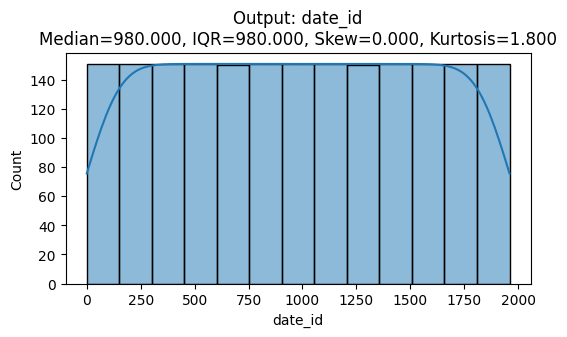

date_id: Median=980.000, IQR=980.000, Skew=0.000, Kurtosis=1.800 



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


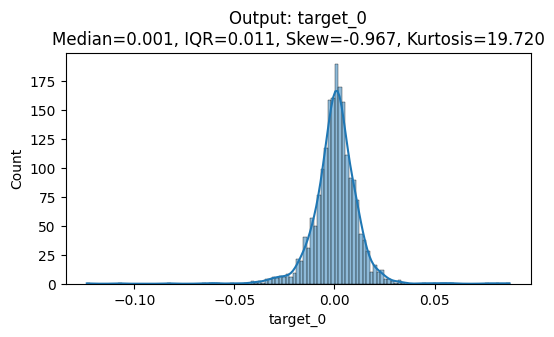

target_0: Median=0.001, IQR=0.011, Skew=-0.967, Kurtosis=19.720 Fat-tailed



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


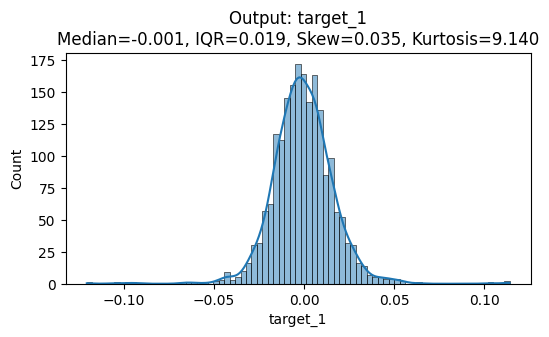

target_1: Median=-0.001, IQR=0.019, Skew=0.035, Kurtosis=9.140 Fat-tailed



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


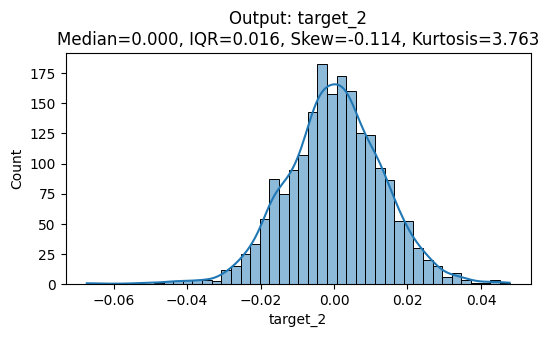

target_2: Median=0.000, IQR=0.016, Skew=-0.114, Kurtosis=3.763 Fat-tailed



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


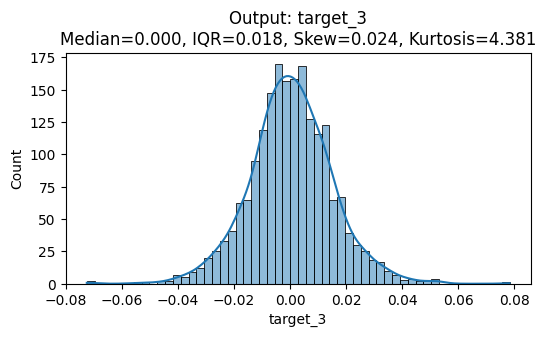

target_3: Median=0.000, IQR=0.018, Skew=0.024, Kurtosis=4.381 Fat-tailed



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


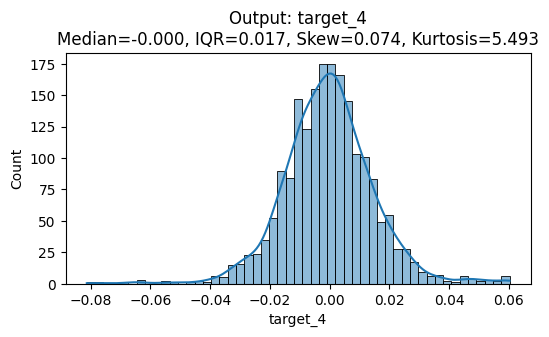

target_4: Median=-0.000, IQR=0.017, Skew=0.074, Kurtosis=5.493 Fat-tailed



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


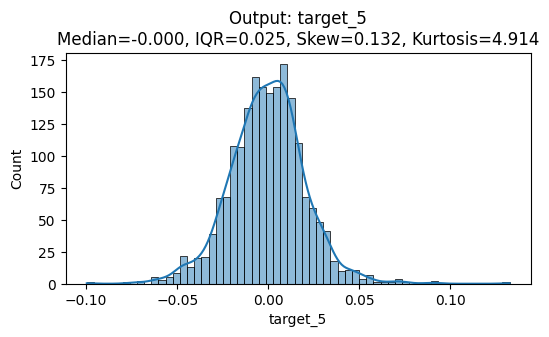

target_5: Median=-0.000, IQR=0.025, Skew=0.132, Kurtosis=4.914 Fat-tailed



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


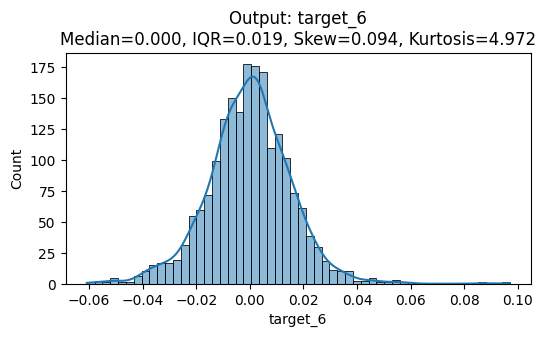

target_6: Median=0.000, IQR=0.019, Skew=0.094, Kurtosis=4.972 Fat-tailed



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


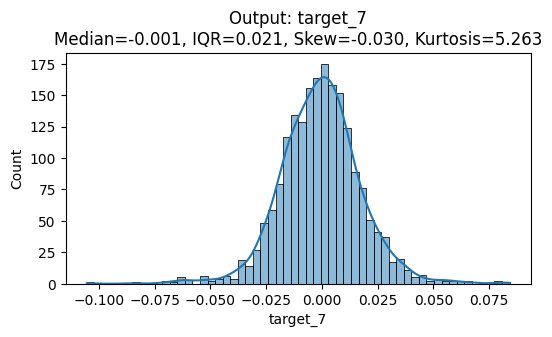

target_7: Median=-0.001, IQR=0.021, Skew=-0.030, Kurtosis=5.263 Fat-tailed



In [73]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

def analyze_and_plot(df, columns, name="Variable"):
    for col in columns:
        # Get the column as a Polars Series, then convert to numpy and drop nulls
        series = df[col]
        # Remove nulls (Polars)
        data = series.drop_nulls().to_numpy()
        med = np.median(data)
        iqr = np.percentile(data, 75) - np.percentile(data, 25)
        sk = skew(data)
        kurt_val = kurtosis(data, fisher=False)  # Use normal=3, so compare to kurtosis=3

        # Plot
        plt.figure(figsize=(6,3))
        sns.histplot(data, kde=True)
        plt.title(f'{name}: {col}\nMedian={med:.3f}, IQR={iqr:.3f}, Skew={sk:.3f}, Kurtosis={kurt_val:.3f}')
        plt.xlabel(col)
        plt.show()

        # Classification of fat tails
        fat_tailed = kurt_val > 3
        print(f'{col}: Median={med:.3f}, IQR={iqr:.3f}, Skew={sk:.3f}, Kurtosis={kurt_val:.3f} {"Fat-tailed" if fat_tailed else ""}\n')

# If X and y are Polars DataFrames, you do NOT need to convert to Polars again
# input_columns and output_columns should be lists of column names
input_columns = X.columns
output_columns = y[:, :9].columns
print("Input feature distributions:")
analyze_and_plot(X, input_columns, name="Input")

print("Output variable distributions:")
analyze_and_plot(y[:, :9], output_columns, name="Output")

Dimensionality reduction and min max scaler. 

In [8]:
from sklearn.manifold import Isomap
from sklearn.preprocessing import MinMaxScaler
# Use only selected features, if desired. For now, use all for demonstration:
isomap = Isomap(n_components=10)  # choose n_components based on analysis
X_iso = isomap.fit_transform(x)
#X_iso = np.log10(np.abs(X_iso) + 1e-6)


scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_iso)

In [56]:
def create_windows(X, y, window_size, forecast_steps=2):
    Xs, ys = [], []
    for i in range(len(X) - window_size - forecast_steps + 1):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size:i+window_size+forecast_steps].to_numpy().reshape(-1))

    return np.array(Xs), np.array(ys)


window_size = 150  # example
forecast_steps = 2
#log_returns = np.log(df['price_col']).diff().fillna(0).values  # replace 'price_col'
#X_sequences, y_sequences = create_windows(X_scaled, log_returns, window_size)
log_returns = y # replace 'price_col'
X_sequences, y_sequences = create_windows(X_scaled, log_returns, window_size, forecast_steps=2)



In [57]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_sequences, y_sequences, test_size=0.2, shuffle=False
)


In [61]:
#only selecting first 18 columns
y_train = y_train[:, :18]
y_val = y_val[:, :18]

In [62]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)


(1448, 150, 10) (1448, 18)
(362, 150, 10) (362, 18)


In [67]:
import keras_tuner
import keras
from tensorflow.keras.optimizers import Adam
def build_rnn_model(hp):
    inputs = keras.Input(shape=[None,10])
    x = tf.keras.layers.SimpleRNN(64, return_sequences=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    outputs = tf.keras.layers.Dense(18)(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=Adam(hp.Choice("learning_rate", [1e-4, 1e-3])),loss='MSE')
    return model

In [68]:

import tensorflow as tf
tuner = keras_tuner.Hyperband(
    hypermodel=build_rnn_model,
    objective="val_loss",
    max_epochs=2,                
    factor=3,
    hyperband_iterations=2,       
    distribution_strategy=tf.distribute.MirroredStrategy(),
    directory="results_dir",
    overwrite=True,
)

tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)])

Trial 2 Complete [00h 00m 07s]
val_loss: 175967.78125

Best val_loss So Far: 175157.0
Total elapsed time: 00h 00m 14s


In [69]:
import tensorflow as tf
import keras_tuner
import keras
from tensorflow.keras.optimizers import Adam
def build_model(hp):
    # Input: (batch, timesteps, n_features)
    inputs = tf.keras.Input(shape=(None, 10))  # e.g., 10 tabular features over time
    
    # LSTM encodes the sequence
    lstm_out = tf.keras.layers.LSTM(64, return_sequences=True)(inputs)  # (b, t, 64)
    
    # Multi-head attention on LSTM outputs
    attn_out = tf.keras.layers.MultiHeadAttention(
        num_heads=8, 
        key_dim=64,
        dropout=0.1
    )(lstm_out, lstm_out)  # Self-attention
    
    # Add & Norm (Transformer-style)
    attn_out = tf.keras.layers.Add()([lstm_out, attn_out])
    attn_out = tf.keras.layers.LayerNormalization()(attn_out)
    
    # Optional: Feed forward
    ffn = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64)
    ])(attn_out)
    ffn = tf.keras.layers.Add()([attn_out, ffn])
    ffn = tf.keras.layers.LayerNormalization()(ffn)
    
    # Global pooling or final time step
    x = tf.keras.layers.GlobalAveragePooling1D()(ffn)  # or ffn[:, -1, :]
    
    # Output layer
    outputs = tf.keras.layers.Dense(18)(x)  # Forecast one value
    
    model = tf.keras.Model(inputs, outputs)

    model.compile(optimizer=Adam(hp.Choice("learning_rate", [1e-4, 1e-3])),loss='MSE')
    return model

In [12]:
#model.fit(X_sequences, y_sequences)

In [70]:
tuner = keras_tuner.Hyperband(
    hypermodel=build_model,
    objective="val_loss",
    max_epochs=2,                
    factor=3,
    hyperband_iterations=2,       
    distribution_strategy=tf.distribute.MirroredStrategy(),
    directory="results_dir",
    overwrite=True,
)

tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)])

Trial 2 Complete [00h 00m 44s]
val_loss: 173130.5

Best val_loss So Far: 173130.5
Total elapsed time: 00h 01m 26s


In [15]:
best_hp = tuner.get_best_hyperparameters(1)[0]

print(best_hp)

In [16]:
import polars as pl

test = pl.read_csv('/kaggle/input/mitsui-commodity-prediction-challenge/test.csv')

In [17]:
import numpy as np

# Step 1: Select correct test features
important_features = [
    "US_Stock_YINN_adj_volume",
    "US_Stock_URA_adj_volume",
    "US_Stock_YINN_adj_low",
    "US_Stock_YINN_adj_close",
    "US_Stock_YINN_adj_open",
    "US_Stock_YINN_adj_high",
    "US_Stock_VGLT_adj_volume",
    "US_Stock_SPTL_adj_volume",
    "US_Stock_VGIT_adj_volume",
    "US_Stock_RSP_adj_volume"
]

test_selected = test.select(important_features)
forecast_steps = 2
# Step 2: Impute missing/zero values BEFORE log
for col in important_features:
    col_data = test_selected[col]
    test_selected = test_selected.with_columns([
        col_data.fill_null(col_data.median()).alias(col)
    ])

# Step 3: Convert to numpy and log-transform
test_np = test_selected.to_numpy()
test_logged = np.log10(test_np + 1e-6)
test_logged = np.nan_to_num(test_logged, nan=0.0, posinf=0.0, neginf=0.0)

# Step 4: Isomap transform (use the fitted isomap from the training pipeline)
test_reduced = isomap.transform(test_logged)

# Step 5: Ensure float32 dtype
test_final = test_reduced.astype(np.float32)

# Suppose window_size = 30
def create_test_windows(test_data, window_size):
    windows = []
    for i in range(len(test_data) - window_size + 1):
        windows.append(test_data[i:i+window_size])
    return np.array(windows)

window_size = 30  # Same size as training!
test_windows = create_test_windows(test_final, window_size)

# Step 6: Build and predict with best model
best_model = tuner.hypermodel.build(best_hp)
y_pred = best_model.predict(test_windows)

# Step 7: If forecasting multiple steps and targets, reshape as needed
y_pred_reshaped = y_pred.reshape(-1, forecast_steps, 9)  # (samples, steps, targets)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


In [18]:
import polars as pl

# Create submission DataFrame
submission = pl.DataFrame({
    'label': y_pred_reshaped.flatten()  # Use float predictions, shape (n_predictions,)
})

# Save to CSV -- SAVE IN CURRENT WORKING DIRECTORY (e.g., './submission.csv')
submission.write_csv('submission.csv')



Conclusion: I decided to use the mitsui and Co commodity prediction challenge dataset where the goal is prediction of the log returns of 9 commoditeis. I chose to try to forecast about 2 timesteps into the future. much of the input data was either bimodal or skewed and much of the output data was vaguely bell curved but had significant skewed and fat tailed. In order to create an algorithm that could hanlde these issues I decided first to take the log10 of the input data. I then decided to use isomap to carry out dimensionality reduction. I chose this over PCA because the distributionsm skew and fat tailed nature implied data that was highly nonlinear which isomap is better euqipped to handle then PCA. THe fat tails and skew also implies long term dedpendence in the data which implies that past events have a major impact on future events. If past events had no impact on present or future returns then we would have seen a perfectly gaussian distribution. This was what drove me to create a deep learning architecture that would utilize LSTM and multi-head attention, both of which are well suited for data that has long term dependence. I also chose to use batch normalization in order to improve the loss and stabilize the training. I only used PCA to weed out the features that had very little impact on the final log returns

My suspicion that the attention with LSTM would work better was confirmed when the loss for the LSTM with attention was much lower then the loss for the classic RNN 